# 8.5 Batch Normalization

## Preparation

In [1]:
# These are the libraries will be used for this lab.

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

## Neural Network Module and Training Function

In [2]:
# Define the Neural Network Model using Batch Normalization
class NetBatchNorm(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))
        x = self.bn2(torch.sigmoid(self.linear2(x)))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

In [3]:
# Class Net for Neural Network Model
class Net(nn.Module):
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 

In [4]:
# Define the function to train model
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

## Make Some Data

In [5]:
# load the train dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
# load the train dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [7]:
# Create Data Loader for both train and validating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

## Define Neural Network, Criterion function, Optimizer and Train the Model

In [8]:
# Create the criterion function
criterion = nn.CrossEntropyLoss()

In [9]:
# Set the parameters
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

## Train Neural Network using Batch Normalization and no Batch Normalization

In [10]:
# Create model, optimizer and train the model
model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)

In [11]:
# Create model without Batch Normalization, optimizer and train the model
model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

## Analyze Results

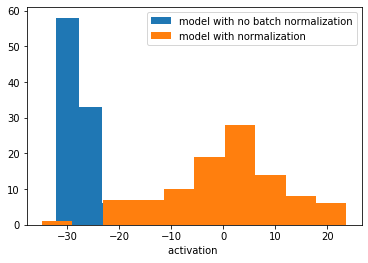

In [12]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

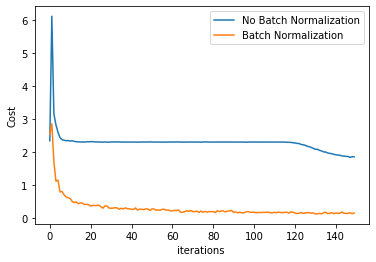

In [13]:
# Plot the diagram to show the loss
plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

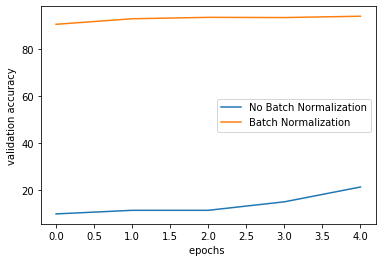

In [14]:
# Plot the diagram to show the accuracy
plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()